<a href="https://colab.research.google.com/github/BDH-teacher/Deep_Learning_Audit_code/blob/main/Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== [Method 1] Data / Vocab ===
num_tokens: 84
vocab_size: 61
top10: ['algorithms', 'to', 'Machine', 'learning', 'is', 'of', 'as', 'a', 'the', 'computer']

=== [Method 1] Training pairs(one-hot) ===
X shape: (330, 61) | y shape: (330, 61)
Example (first 1):
X[0] = [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
y[0] = [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



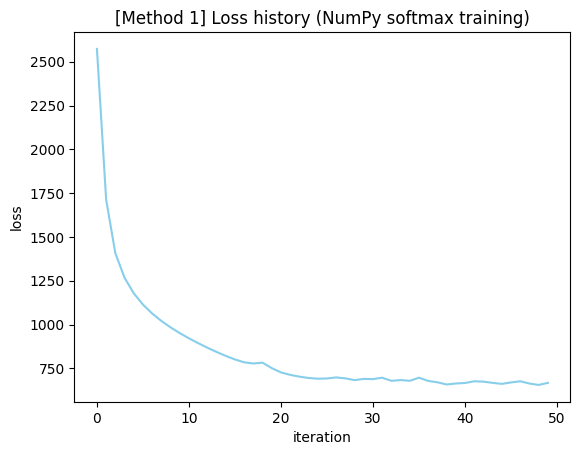


=== [Method 1] Learned distributional representations (W1) ===
  algorithms -> [ 0.11117337 -0.78179457 -1.04980883  2.0667228   0.59235504 -0.55774833] ...
          to -> [ 0.35455227 -0.30959616  1.25018126  0.80835035 -0.93008787  0.37221446] ...
     Machine -> [ 1.92627616 -0.67598401 -0.57624589 -0.66809182  1.21700567  1.04617794] ...
    learning -> [ 1.55215981 -0.0602866   1.00193395 -0.05237418  0.14963417  0.46739675] ...
          is -> [ 1.50213006  0.21094242  1.01962723 -1.22708912  0.43341075  1.05155221] ...
          of -> [ 0.52822372  0.8392883  -0.22223402  0.54945531 -0.6171749   0.248808  ] ...


In [1]:
# Language Model / Word2Vec-style (from scratch + PyTorch)

import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt


# Method 1: One-hot -> distributional representations (NumPy)
# Step1 : Prepare data, choose tokenization metric, construct vocabulary
text = '''Machine learning is the study of computer algorithms that improve automatically through experience. It is seen
as a subset of artificial intelligence. Machine learning algorithms build a mathematical model based on sample data, known
as training data, in order to make predictions or decisions without being explicitly programmed to do so. Machine
learning algorithms are used in a wide variety of applications, such as email filtering and computer vision, where it is
difficult or infeasible to develop conventional algorithms to perform the needed tasks.'''

# Tokenization
words = text.split()

from collections import Counter
## Build a dictionary that maps words to integers
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
word_to_id = {word: ii for ii, word in enumerate(vocab, 0)}

vocab_to_int = word_to_id

print("=== [Method 1] Data / Vocab ===")
print("num_tokens:", len(words))
print("vocab_size:", len(word_to_id))
print("top10:", vocab[:10])
print()


# Step2 : Construct context-target pairs (code implementation)
def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)

    for i in range(n_tokens):
        context_idx = []
        for k in range(max(0, i - window), i):
            context_idx.append(k)

        for k in range(i+1, min(n_tokens, i + window + 1)):
            context_idx.append(k)

        for j in context_idx:
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))

    return np.asarray(X), np.asarray(y)

def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

X, y = generate_training_data(words, word_to_id, 2)

print("=== [Method 1] Training pairs(one-hot) ===")
print("X shape:", X.shape, "| y shape:", y.shape)
print("Example (first 1):")
print("X[0] =", X[0])
print("y[0] =", y[0])
print()


# Step3 : Define a Model (W1 and W2)
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

model = init_network(len(vocab_to_int), 10)


# Step4 : forward pass
def softmax(a):
    # 최소 구현(안정화)
    a = a - np.max(a, axis=1, keepdims=True)
    expa = np.exp(a)
    return expa / np.sum(expa, axis=1, keepdims=True)

def forward(model, X):
    cache = {}
    cache["a1"] = np.dot(X, model["w1"])
    cache["a2"] = np.dot(cache["a1"], model["w2"])
    cache["z"] = softmax(cache["a2"])
    return cache


# Step5 : backward + cross-entropy
def backward(model, x, y, alpha):
    cache = forward(model, x)
    da2 = cache["z"] - y
    dw2 = np.dot(cache["a1"].T, da2)
    da1 = np.dot(da2, model["w2"].T)
    dw1 = np.dot(x.T, da1)
    assert dw2.shape == model["w2"].shape
    assert dw1.shape == model["w1"].shape
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

def cross_entropy(z, y):
    return -np.sum(np.log(z + 1e-15) * y)


# Step6 : Train and confirm loss values
import matplotlib.pyplot as plt
# matplotlib inline
# %config InlineBackend.figure_format = 'svg'
# plt.style.use("seaborn")

n_iter = 50
learning_rate = 0.05

loss_history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(loss_history)), loss_history, color="skyblue")
plt.title("[Method 1] Loss history (NumPy softmax training)")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

# W1의 각 row가 "단어 임베딩" (one-hot * W1 = 해당 단어 벡터)
W1 = model["w1"]  # (vocab_size, emb_dim)
print("\n=== [Method 1] Learned distributional representations (W1) ===")
for w in vocab[:6]:
    print(f"{w:>12s} -> {W1[word_to_id[w]][:6]} ...")  # 앞 6차원만 출력

In [2]:
# Method 2: Using input_ids (indices information) with PyTorch
# embedding lookup + torch.mul + torch.sum + sigmoid

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice:", device)


# (Step2) Prepare pairs using indices
def make_pairs(tokens, window=2):
    pairs = []
    n = len(tokens)
    for i in range(n):
        for j in range(max(0, i-window), min(n, i+window+1)):
            if i == j:
                continue
            pairs.append((tokens[i], tokens[j]))  # (target, context)
    return pairs

pairs = make_pairs(words, window=2)
print("\n=== [Method 2] pairs example ===")
print("num_pairs:", len(pairs))
print("first 10:", pairs[:10])


# score = sum( target_vec * context_vec ) -> sigmoid(score)
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # input / output embedding 분리
        self.input_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output_embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, input_word, context_word, negative_words=None):
        # input_word: [1], context_word: [1]
        v = self.input_embeddings(input_word)     # (1, D)
        u = self.output_embeddings(context_word)  # (1, D)

        # torch.mul(v, u) -> elementwise product
        # torch.sum(...) -> dot product
        score = torch.sum(torch.mul(v, u), dim=1)           # (1,)
        pos_loss = -torch.log(torch.sigmoid(score) + 1e-15) # (1,)

        if negative_words is None:
            return pos_loss.mean()

        # negative sampling
        neg_u = self.output_embeddings(negative_words)      # (K, D)
        neg_score = torch.sum(v * neg_u, dim=1)             # (K,)
        neg_loss = -torch.log(torch.sigmoid(-neg_score) + 1e-15).mean()

        return pos_loss.mean() + neg_loss


vocab_size = len(word_to_id)
embedding_dim = 10
model2 = SkipGramModel(vocab_size, embedding_dim).to(device)

learning_rate = 0.01
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
epochs = 50

# negative sampling helper
def sample_negative(vocab_size, forbidden_ids, K=5):
    # forbidden_ids: set of ids to avoid (e.g., positive target/context)
    negs = []
    while len(negs) < K:
        r = random.randrange(vocab_size)
        if r not in forbidden_ids:
            negs.append(r)
    return negs

# Step6 Train API
# ---------------------------------------------------------
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# epochs = 50
# import random
# # Training loop
# for epoch in range(epochs):
#     total_loss = 0
#     random.shuffle(pairs)
#     for target, context in pairs:
#         input_word = torch.tensor([word_to_id[target]], dtype=torch.long)
#         context_word = torch.tensor([word_to_id[context]], dtype=torch.long)
#
#         # Zero gradients
#         optimizer.zero_grad()
#
#         # Forward pass
#         loss = model(input_word, context_word)#, negative_words)
#
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
#
#         total_loss += loss.item()
#     if (epoch + 1) % 10 == 0:
#         print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(pairs):.10f}")
# ---------------------------------------------------------

print("\n=== [Method 2] Training (PyTorch) ===")
for epoch in range(epochs):
    total_loss = 0.0
    random.shuffle(pairs)

    for target, context in pairs:
        input_word = torch.tensor([word_to_id[target]], dtype=torch.long, device=device)
        context_word = torch.tensor([word_to_id[context]], dtype=torch.long, device=device)

        # negative words 샘플링
        forb = {word_to_id[target], word_to_id[context]}
        neg_ids = sample_negative(vocab_size, forb, K=5)
        negative_words = torch.tensor(neg_ids, dtype=torch.long, device=device)

        optimizer.zero_grad()

        # Forward pass
        loss = model2(input_word, context_word, negative_words)  # , negative_words

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(pairs):.10f}")


Device: cpu

=== [Method 2] pairs example ===
num_pairs: 330
first 10: [('Machine', 'learning'), ('Machine', 'is'), ('learning', 'Machine'), ('learning', 'is'), ('learning', 'the'), ('is', 'Machine'), ('is', 'learning'), ('is', 'the'), ('is', 'study'), ('the', 'learning')]

=== [Method 2] Training (PyTorch) ===
Epoch 10/50, Loss: 0.7911088880
Epoch 20/50, Loss: 0.5349874253
Epoch 30/50, Loss: 0.4722544733
Epoch 40/50, Loss: 0.4751990786
Epoch 50/50, Loss: 0.3995071126



Word Embeddings Shape: torch.Size([61, 10])

=== t-SNE on top words ===
             y
0   algorithms
1           to
2      Machine
3     learning
4           is
5           of
6           as
7            a
8          the
9     computer
10       data,
11          in
[t-SNE] Computing 11 nearest neighbors...
[t-SNE] Indexed 12 samples in 0.001s...
[t-SNE] Computed neighbors for 12 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 12 / 12
[t-SNE] Mean sigma: 1.751627
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.694824


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 500 iterations: 0.248270


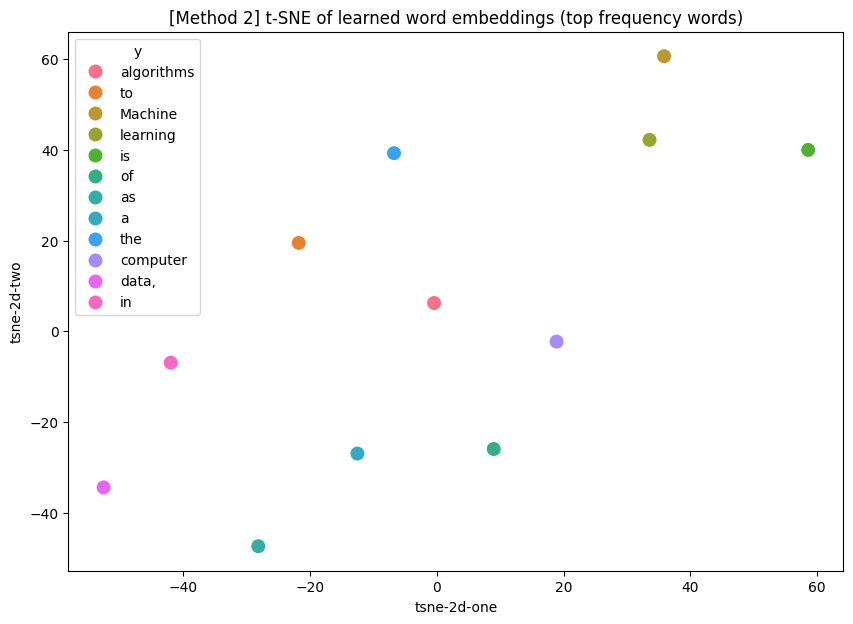

In [3]:
# Check Embedding!
embeddings = model2.input_embeddings.weight.data
print("\nWord Embeddings Shape:", embeddings.shape)


# t-SNE evaluation ('Now it’s time to use T-SNE evaluation')
top_k = 12
top_words = [w for w, _ in counts.most_common(top_k)]
top_ids = [word_to_id[w] for w in top_words]

data_subset = embeddings[top_ids].detach().cpu().numpy()
df_subset = pd.DataFrame({"y": top_words})

print("\n=== t-SNE on top words ===")
print(df_subset)

tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=500, random_state=0)
tsne_results = tsne.fit_transform(data_subset)
df_subset["tsne-2d-one"] = tsne_results[:, 0]
df_subset["tsne-2d-two"] = tsne_results[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="y",
    data=df_subset,
    s=120
)
plt.title("[Method 2] t-SNE of learned word embeddings (top frequency words)")
plt.show()